# Mario Kart AI

Inspired by [TensorKart](https://github.com/kevinhughes27/TensorKart)

Scripts:
- [record.py](scripts/record.py)
- [utils.py](scripts/utils.py)
    - load_sample
    - viewer
    - prepare
    - ...
- [train.py](scripts/train.py)
- [play.py](scripts/play.py)
- [debugging.ipynb](scripts/debugging.ipynb)

## Play around with recorded data

In [1]:
def load_sample(sample):
    image_files = np.loadtxt(sample + '/data.csv', delimiter=',', dtype=str, usecols=(0,))
    joystick_values = np.loadtxt(sample + '/data.csv', delimiter=',', usecols=(1,2,3,4,5))
    return image_files, joystick_values


The samples had not originally been stored in a dedicated folder (with the name of day of recording, and the number of recording)

In [2]:
import numpy as np
image_files, joystick_values = load_sample('samples/2021-10-11-1')
image_files[48],joystick_values[48]

('samples/2021-10-11-1/img_48.png',
 array([-0.04724121, -0.01574707,  1.        ,  0.        ,  0.        ]))

3   [-0.02362061 -0.00787354  0.          0.          0.        ]


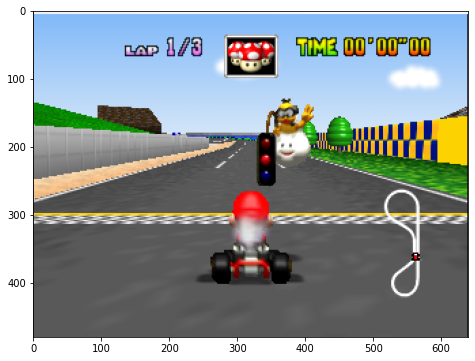

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_files, joystick_values = load_sample('samples/2021-10-11-1')

plt.ion()
plt.figure('viewer', figsize=(16, 6))

# for i in range(len(image_files)):
i=3
# joystick
print(i, " ", joystick_values[i,:])
image_file = image_files[i]
img = mpimg.imread(image_file)
plt.imshow(img)


-0.02362060546875


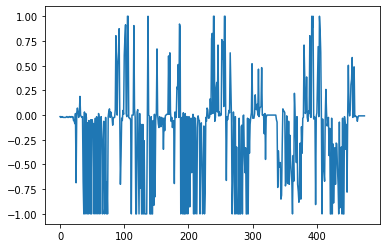

In [4]:
# Plot joystick x values

print(joystick_values[3,0])

plt.plot(joystick_values[:,0])

## Prepare Data

In [5]:
import pandas as pd
data = pd.DataFrame({'center':image_files,'steering': joystick_values[:,0]})
data

,center,steering
0,samples/2021-10-11-1/img_0.png,-0.015747
1,samples/2021-10-11-1/img_1.png,-0.023621
2,samples/2021-10-11-1/img_2.png,-0.015747
3,samples/2021-10-11-1/img_3.png,-0.023621
4,samples/2021-10-11-1/img_4.png,-0.015747
...,...,...
470,samples/2021-10-11-1/img_470.png,-0.007874
471,samples/2021-10-11-1/img_471.png,-0.007874
472,samples/2021-10-11-1/img_472.png,-0.007874
473,samples/2021-10-11-1/img_473.png,-0.007874


total data: 475


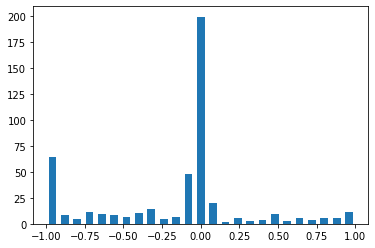

In [6]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
print('total data:', len(data))

In [7]:
image_paths = data['center']
steerings = data['steering']

In [8]:
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 380
Valid Samples: 95


Text(0.5, 1.0, 'Validation set')

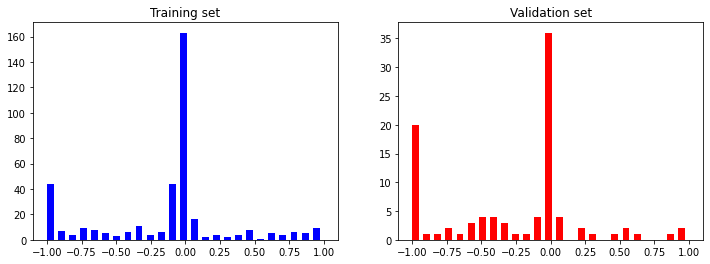

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Preprocess Images

In [10]:
class Sample:
    IMG_W = 200
    IMG_H = 66
    IMG_D = 3

# Global variable
OUT_SHAPE = 5
INPUT_SHAPE = (Sample.IMG_H, Sample.IMG_W, Sample.IMG_D)

In [11]:
from skimage.transform import resize
from skimage.io import imread

In [12]:
def resize_image(img):
    im = resize(img, (Sample.IMG_H, Sample.IMG_W, Sample.IMG_D))
    im_arr = im.reshape((Sample.IMG_H, Sample.IMG_W, Sample.IMG_D))
    return im_arr

In [13]:
# prepare training data
def prepare(samples):
    print("Preparing data")

    X = []
    y = []

    for sample in samples:
        print(sample)

        # load sample
        image_files, joystick_values = load_sample(sample)

        # add joystick values to y
        y.append(joystick_values)

        # load, prepare and add images to X
        for image_file in image_files:
            image = imread(image_file)
            vec = resize_image(image)
            X.append(vec)

    print("Saving to file...")
    X = np.asarray(X)
    y = np.concatenate(y)

    np.save("data/X", X)
    np.save("data/y", y)

    print("Done!")
    return

In [14]:
prepare(['samples/2021-10-11-1'])

Preparing data
samples/2021-10-11-1
Saving to file...
Done!


## Train model

In [15]:
x_train = np.load("data/X.npy")
y_train = np.load("data/y.npy")

print(x_train.shape[0], 'train samples')

475 train samples


(66, 200, 3)


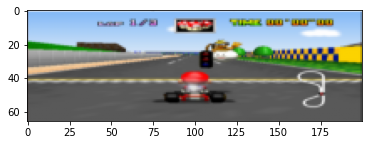

In [16]:
print(x_train[0].shape)
plt.imshow(x_train[0])

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
# from keras import optimizers
from keras import backend as K


In [18]:
def create_model(keep_prob = 0.8):
    model = Sequential()

    # NVIDIA's model
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape= INPUT_SHAPE))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    drop_out = 1 - keep_prob
    model.add(Dropout(drop_out))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(OUT_SHAPE, activation='softsign'))

    return model

In [19]:
def customized_loss(y_true, y_pred, loss='euclidean'):
    # Simply a mean squared error that penalizes large joystick summed values
    if loss == 'L2':
        L2_norm_cost = 0.001
        val = K.mean(K.square((y_pred - y_true)), axis=-1) \
                    + K.sum(K.square(y_pred), axis=-1)/2 * L2_norm_cost
    # euclidean distance loss
    elif loss == 'euclidean':
        val = K.sqrt(K.sum(K.square(y_pred-y_true), axis=-1))
    return val

In [20]:
# Training loop variables
epochs = 100
batch_size = 50

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 1164)              1

In [21]:
model.compile(loss=customized_loss, optimizer=Adam())
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)

Epoch 1/100
9/9 [==============================] - 7s 269ms/step - loss: 0.9605 - val_loss: 0.7898
Epoch 2/100
9/9 [==============================] - 2s 256ms/step - loss: 0.9048 - val_loss: 0.7782
Epoch 3/100
9/9 [==============================] - 2s 229ms/step - loss: 0.8909 - val_loss: 0.7636
Epoch 4/100
9/9 [==============================] - 2s 226ms/step - loss: 0.8685 - val_loss: 0.7473
Epoch 5/100
9/9 [==============================] - 2s 246ms/step - loss: 0.8553 - val_loss: 0.7299
Epoch 6/100
9/9 [==============================] - 2s 241ms/step - loss: 0.8317 - val_loss: 0.7138
Epoch 7/100
9/9 [==============================] - 2s 246ms/step - loss: 0.8165 - val_loss: 0.6967
Epoch 8/100
9/9 [==============================] - 2s 235ms/step - loss: 0.8118 - val_loss: 0.6886
Epoch 9/100
9/9 [==============================] - 2s 223ms/step - loss: 0.7901 - val_loss: 0.6754
Epoch 10/100
9/9 [==============================] - 2s 226ms/step - loss: 0.7795 - val_loss: 0.6699
Epoch 11/

In [22]:
model.save_weights('models/model_weights_2021-10-11-1_100epochs.h5')

Text(0.5, 0, 'Epoch')

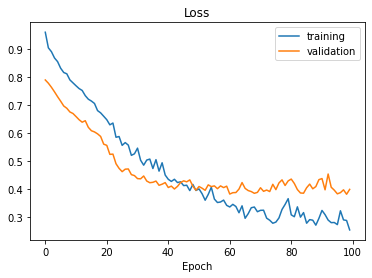

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

## Load model

In [24]:
import os
os.chdir('scripts')
from train import create_model
model = create_model(keep_prob=1)
os.chdir('..')

In [26]:
model.load_weights("models/model_weights_2021-10-11-1_100epochs.h5")

## Test model

In [27]:
# x_train[0].shape
vec = np.expand_dims(x_train[0], axis=0) # expand dimensions for predict, it wants (1,66,200,3) not (66, 200, 3)
model.predict(vec)

array([[-0.02474702, -0.0177073 ,  0.09645139,  0.00655219,  0.0066537 ]],
      dtype=float32)

[-0.01574707 -0.00787354  0.          0.          0.        ]


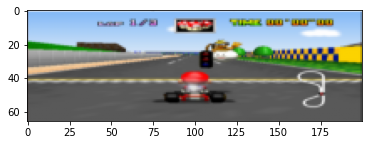

In [28]:
print(y_train[0])
plt.imshow(x_train[0])